In [5]:
import sys
sys.path.append('/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import multiprocessing

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error

numOfExperiment = 3

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
graph1 = load_dicty()
graph2 = load_pharma()

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1219
3	ann-(1219, 116), expr-(1219, 282), ppi-(1219, 1219)
0	
Experimental condition	282
0	
1	expr-(1219, 282)
GO term	116
0	
1	ann-(1219, 116)

0.0
1.0

0.0
1.0

0.0
1.0

0.0
1.0

0.0
1.0

0.0
1.0

-------------RelationGraph-------------
Depositor	189
1	depo_cats-(189, 16)
1	depositors-(1260, 189)
Depositor category	16
0	
1	depo_cats-(189, 16)
Action	130
0	
1	actions-(1260, 130)
PMID	7948
0	
1	pudmed-(1260, 7948)
Chemical	1260
5	actions-(1260, 130), pudmed-(1260, 7948), depositors-(1260, 189), fingerprints-(1260, 920), tanimoto-(1260, 1260)
0	
Fingerprint	920
0	
1	fingerprints-(1260, 920)



In [3]:
def data_generator(filenames, n_pack):
    # n_pack => 100 samples of matrix
    # n_pack = batch_size
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        for i in range(len(files)):
            rand_num = np.random.randint(len(num_packs[i]))
            f = files[i]
            pack = num_packs[i]
            x.append(f[pack[rand_num]])
            
        yield (x, x)
        
        if counter >= n_pack:
            counter = 0
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data
            
    
class MultiModal:
    
    def __init__(self, graph=None, path=''):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        self._input_layer(relation.matrix.shape)
        
        row, col = relation.matrix.shape
        self.org_data.append(np.array(relation.matrix).reshape(1,row,col,1))
        self.input_data_size.append(relation.matrix.shape)
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
        
#         Conv2D filtered by columns
        layer1 = Conv2D(64, (1, col-7), activation='relu', padding='valid')(visible)
        layer1 = MaxPooling2D((2, 2))(layer1)
        layer1 = Conv2D(32, (3, 3), activation='relu')(layer1)
        layer1 = MaxPooling2D((2, 2))(layer1)
        layer1 = Conv2D(1, (1, 1), activation='relu')(layer1)
        layer1 = Flatten()(layer1)
        
        layer2 = Conv2D(64, (1, col-7), activation='relu', padding='valid')(visible)
        layer2 = MaxPooling2D((2, 2))(layer2)
        layer2 = Conv2D(32, (3, 3), activation='relu')(layer2)
        layer2 = MaxPooling2D((2, 2))(layer2)
        layer2 = Conv2D(1, (1, 1), activation='relu')(layer2)
        layer2 = Flatten()(layer2)
        
        layer = concatenate([layer1, layer2])
        layer = Dense(int((row + col) / 2), activation='relu')(layer)
        
        layer = Dense(1000, activation="relu")(layer)
        layer = Dense(100, activation="relu")(layer)
        layer = Dense(20, activation="relu")(layer) 
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size

        layer = Dense(row, activation='relu')(self.inputs)
        layer = Reshape((row, 1, 1))(layer)
        layer = UpSampling2D((1, col))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        x = Dense(100, activation="relu")(self.inputs)
        x = Dense(1000, activation="relu")(x)
        self.inputs = x
        
    def _callbacks(self):
        log_dir = '/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True),
            EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
        ]
        
    def build_model(self, optimizer='sgd', loss='mse'):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(20, activation="relu")(self.inputs) 
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        self.model.compile(optimizer=optimizer, loss=loss)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, batch_size), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + ' - ' + str(predict_mean) + '\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
       

In [ ]:
model = MultiModal(graph=graph1, path='/data/samples/multiple_inputs/dicty/')
model.build_model(optimizer='sgd', loss='mse')
model.fit(500, 30)
model.save('/data/multimodal/dicty/', str(numOfExperiment))
model.predict()

ann	(1219, 116)
expr	(1219, 282)
ppi	(1219, 1219)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1219, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1219, 282, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1219, 1219, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1219, 8, 64)  7040        input_1[0][0]                    
___________________________________________________________

Epoch 1/30
500/500 [==============================] - 125s 250ms/step - loss: 0.4845 - conv2d_18_loss: 0.1619 - conv2d_19_loss: 0.1704 - conv2d_20_loss: 0.1522
Epoch 2/30
500/500 [==============================] - 113s 226ms/step - loss: 0.3230 - conv2d_18_loss: 0.0852 - conv2d_19_loss: 0.1682 - conv2d_20_loss: 0.0697
Epoch 3/30
500/500 [==============================] - 121s 242ms/step - loss: 0.2751 - conv2d_18_loss: 0.0624 - conv2d_19_loss: 0.1675 - conv2d_20_loss: 0.0452
Epoch 4/30
500/500 [==============================] - 119s 238ms/step - loss: 0.2549 - conv2d_18_loss: 0.0528 - conv2d_19_loss: 0.1673 - conv2d_20_loss: 0.0348
Epoch 5/30
500/500 [==============================] - 116s 232ms/step - loss: 0.2444 - conv2d_18_loss: 0.0478 - conv2d_19_loss: 0.1672 - conv2d_20_loss: 0.0294
Epoch 6/30
500/500 [==============================] - 117s 234ms/step - loss: 0.2381 - conv2d_18_loss: 0.0449 - conv2d_19_loss: 0.1672 - conv2d_20_loss: 0.0261
Epoch 7/30
500/500 [====================

In [6]:
model1 = MultiModal(graph=graph1, path='/data/samples/multiple_inputs/dicty/')
model1.load_model('/data/multimodal/dicty/', str(numOfExperiment))
model1.predict(random=True)

ann	(1219, 116)
expr	(1219, 282)
ppi	(1219, 1219)
Data		Density		Predict		BaseLine	AVG Mean		Predict (min)	Predict (max)	
(1219,116) 	5.34% 		5.06125% 	1.82056% 	0.05341 - 0.00324	0.05827		0.06326	
(1219,282) 	95.19% 		9.6563% 	9.98529% 	0.82182 - 0.54668	0.53822		0.5883	
(1219,1219) 	3.09% 		2.17086% 	1.13859% 	0.0248 - 0.00159	0.04831		0.05353	


(1219, 116)


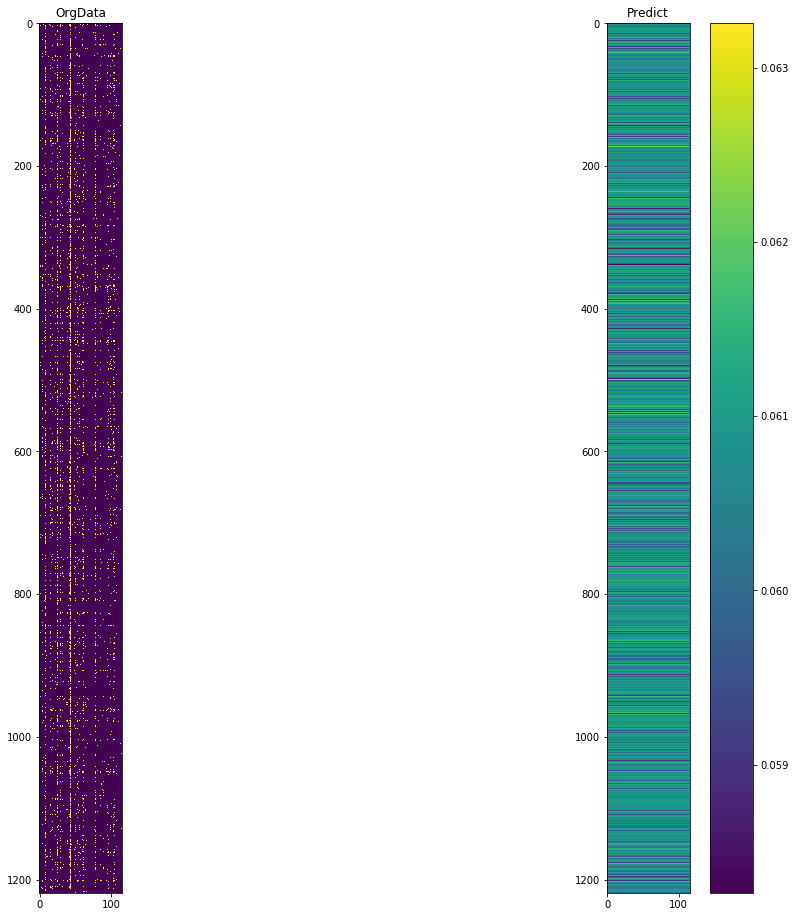

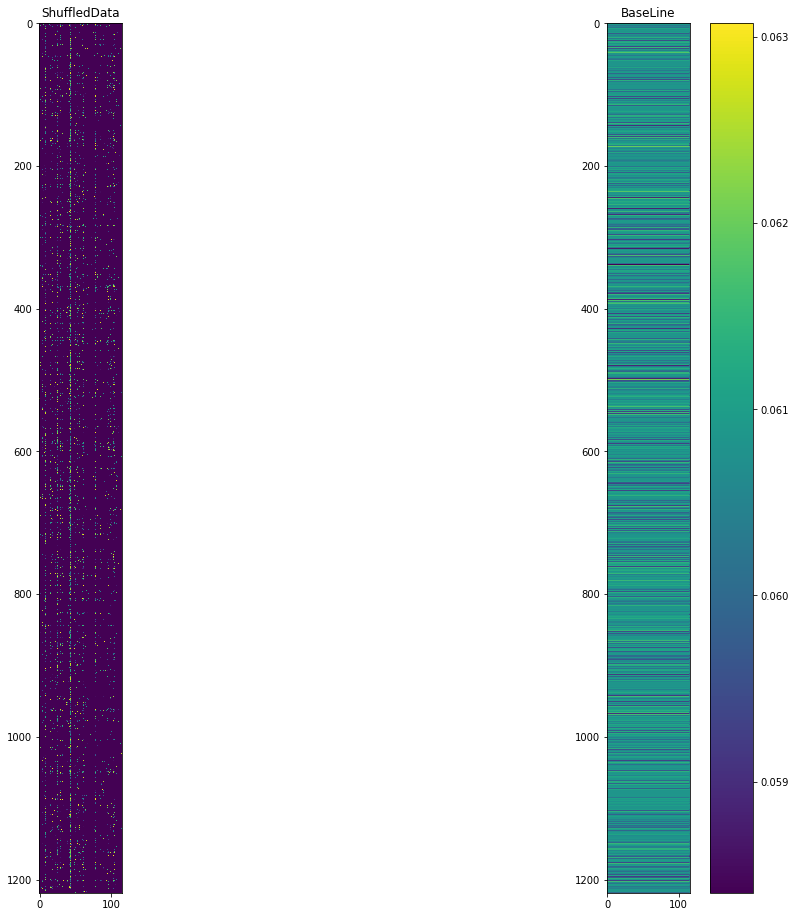

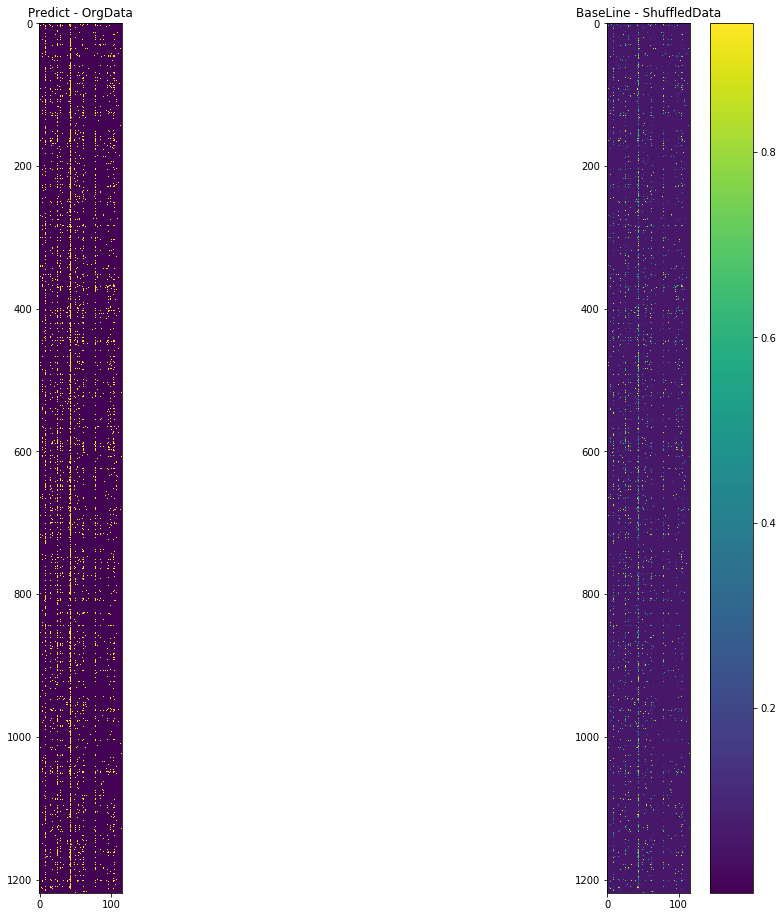

(1219, 282)


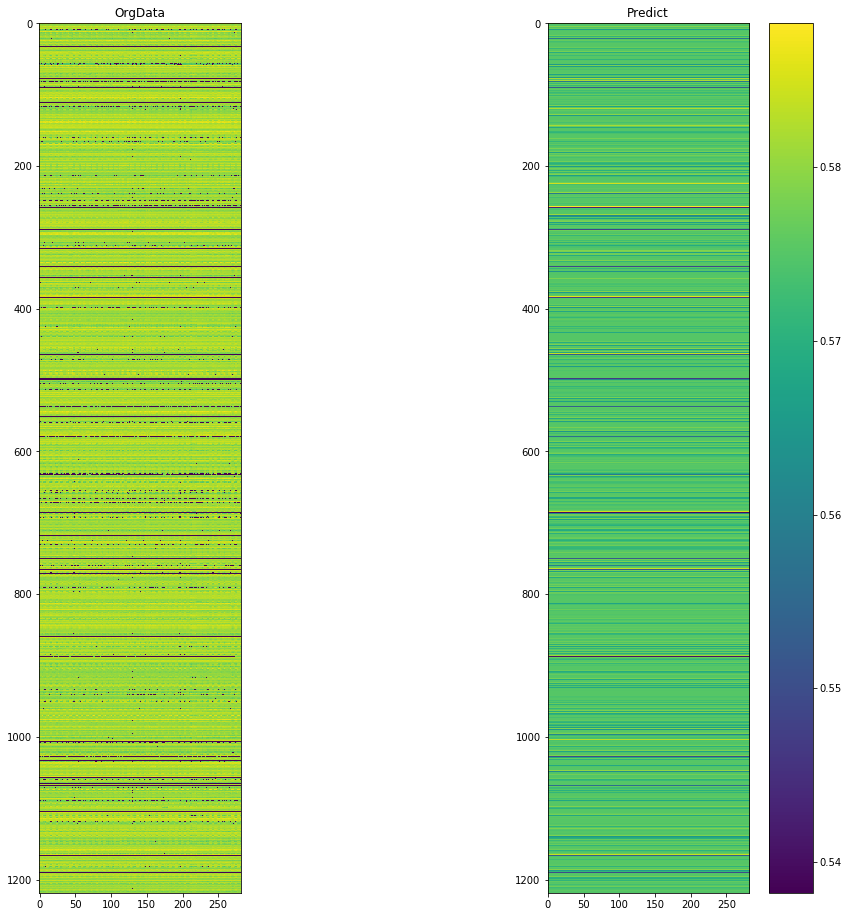

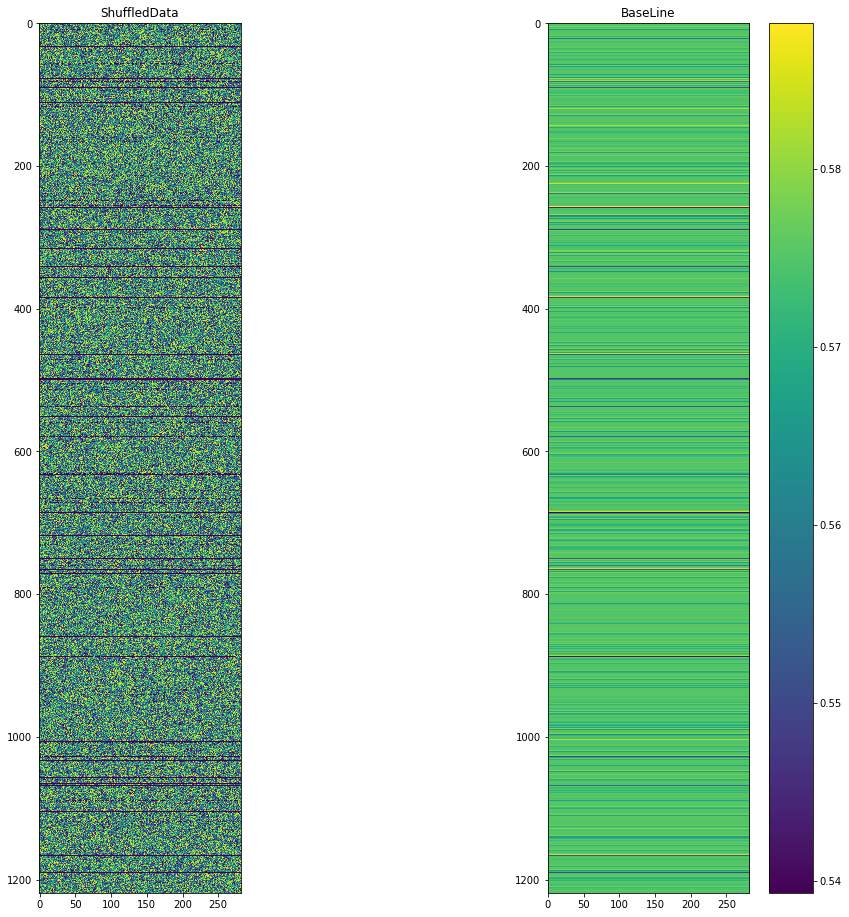

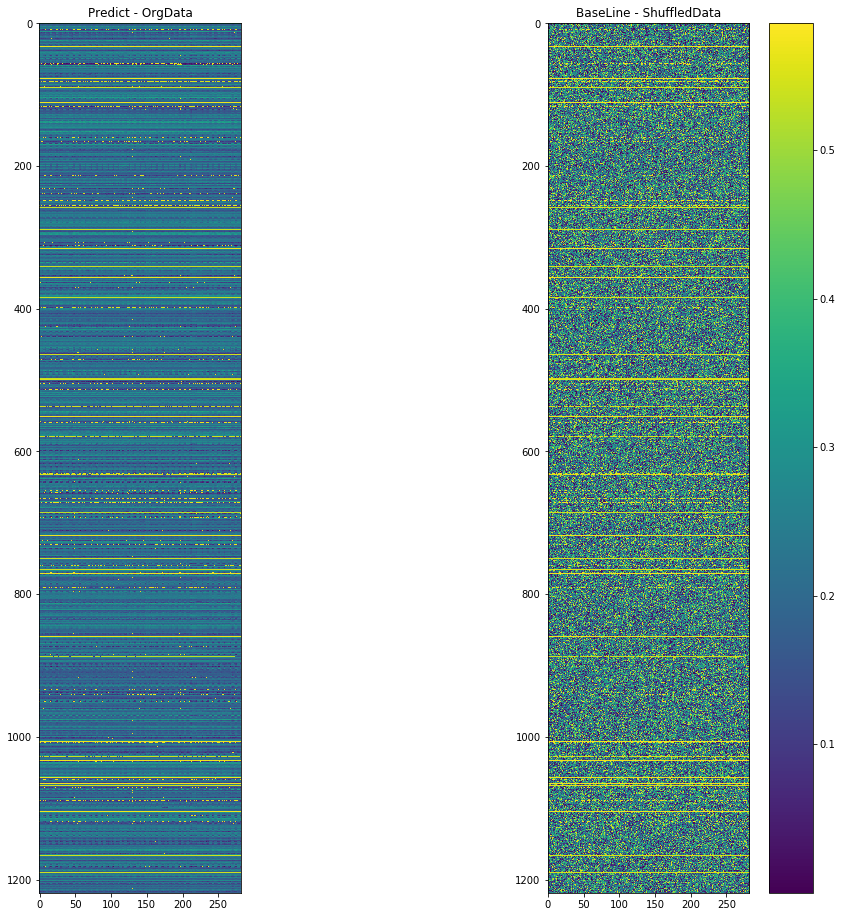

(1219, 1219)


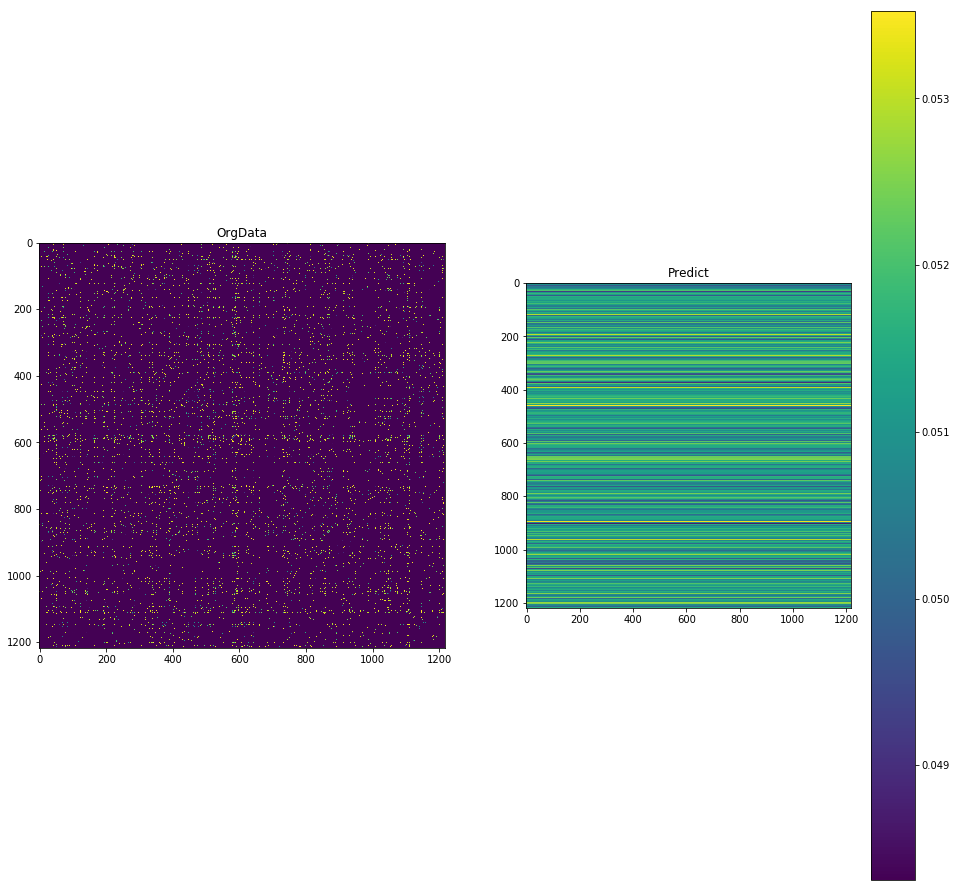

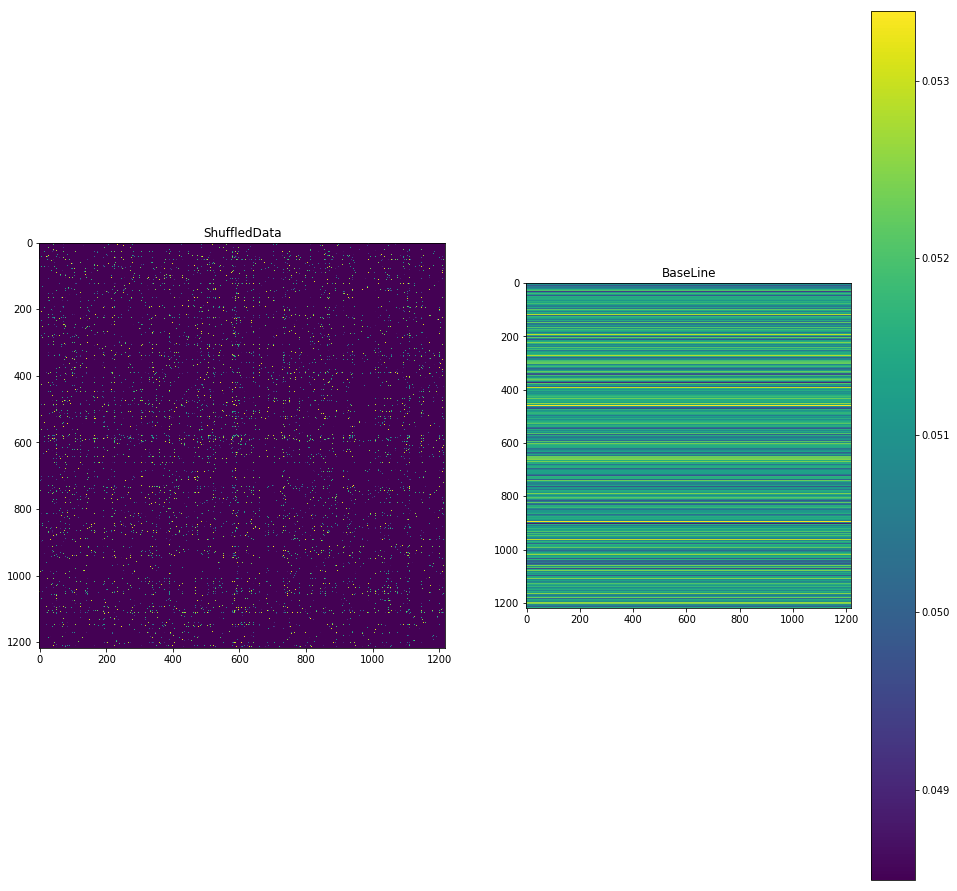

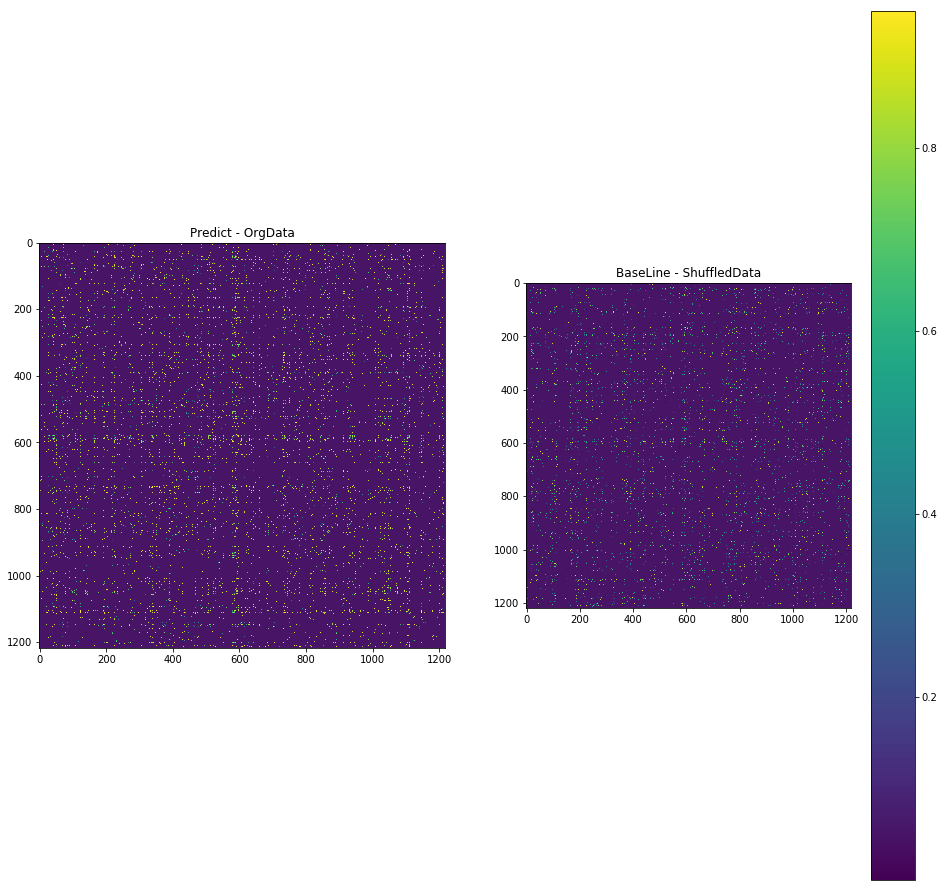

In [8]:
import matplotlib.pyplot as plt

path = '/mag/Experiments/Results/'+ str(numOfExperiment) + '/dicty/'

for i in range(len(model1.org_data)):
    _, row, col, _ = model1.org_data[i].shape
    org_data = model1.org_data[i].reshape(row, col)
    shuffled_data = model1.shuffled_data[i].reshape(row, col)
    predict = model1.predict_data[i].reshape(row, col)
    base_line = model1.base_line[i].reshape(row, col)
    print(org_data.shape)


    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('OrgData')
    plt.imshow(org_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('Predict')
    plt.imshow(predict)
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')
    plt.show()
    plt.close()

    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('ShuffledData')
    plt.imshow(shuffled_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine')
    plt.imshow(base_line)
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_randomData_vs_predictBaseLine.png')
    plt.show()
    plt.close()

    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('Predict - OrgData')
    plt.imshow(np.abs(predict - org_data))
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine - ShuffledData')
    plt.imshow(np.abs(base_line - shuffled_data))
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_intersection.png')
    plt.show()
    plt.close()

In [ ]:
model = MultiModal(graph=graph2, path='/data/samples/multiple_inputs/pharma/')
model.build_model(optimizer='sgd', loss='mse')
model.fit(500, 30)
model.save('/data/multimodal/pharma/', str(numOfExperiment))
model.predict()

fingerprints	(1260, 920)
actions	(1260, 130)
depo_cats	(189, 16)
depositors	(1260, 189)
pudmed	(1260, 7948)
tanimoto	(1260, 1260)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1260, 920, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1260, 130, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 189, 16, 1)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1260, 189, 1) 0                        

Epoch 1/30
490/500 [============================>.] - ETA: 11s - loss: 0.7751 - conv2d_36_loss: 0.1367 - conv2d_37_loss: 0.1428 - conv2d_38_loss: 0.1012 - conv2d_39_loss: 0.2039 - conv2d_40_loss: 0.0742 - conv2d_41_loss: 0.1163

In [5]:
model2 = MultiModal(graph=graph2, path='/data/samples/multiple_inputs/pharma/')
model2.load_model('/data/multimodal/pharma/', str(numOfExperiment))
model2.predict(random=True)

fingerprints	(1260, 920)
actions	(1260, 130)
depo_cats	(189, 16)
depositors	(1260, 189)
pudmed	(1260, 7948)
tanimoto	(1260, 1260)
Data		Density		Predict		BaseLine	AVG Mean		Predict (min)	Predict (max)	
(1260,920) 	13.54% 		12.22585% 	4.3243% 	0.13537 - 0.01059	4e-05		0.22325	
(1260,130) 	4.04% 		4.05256% 	1.47972% 	0.04042 - 0.00123	6e-05		0.15943	
(189,16) 	6.18% 		6.14777% 	2.37852% 	0.06184 - 0.00181	1e-05		0.21067	
(1260,189) 	21.37% 		17.12095% 	6.19327% 	0.2137 - 0.03209	0.00116		0.20945	
(1260,7948) 	0.38% 		0.57259% 	0.34495% 	0.00375 - 9e-05	0.0		0.17579	
(1260,1260) 	99.25% 		7.14392% 	8.59381% 	0.66718 - 0.45333	0.03463		0.92197	


(1260, 920)


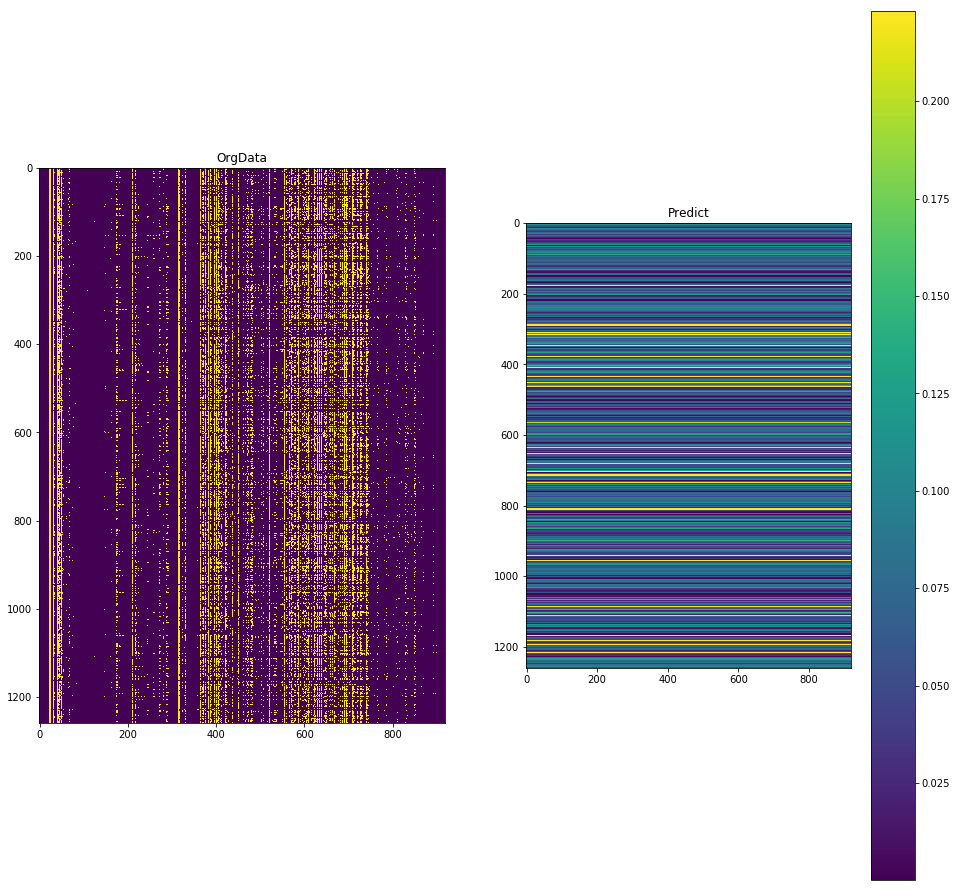

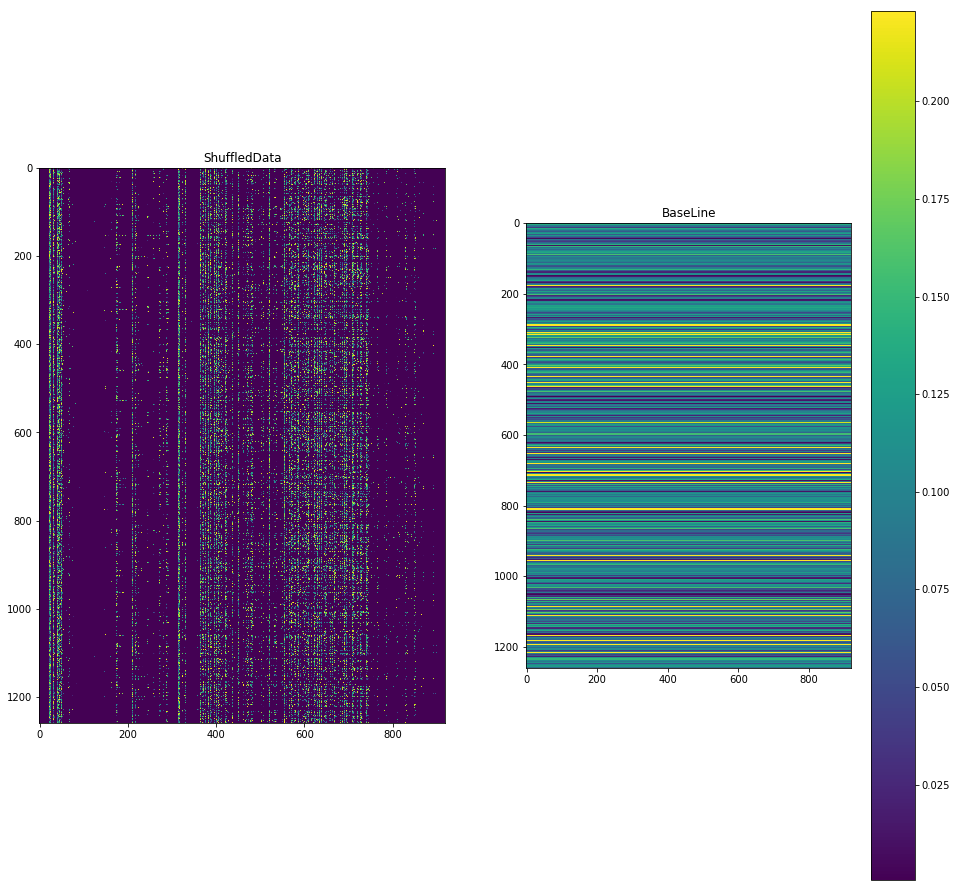

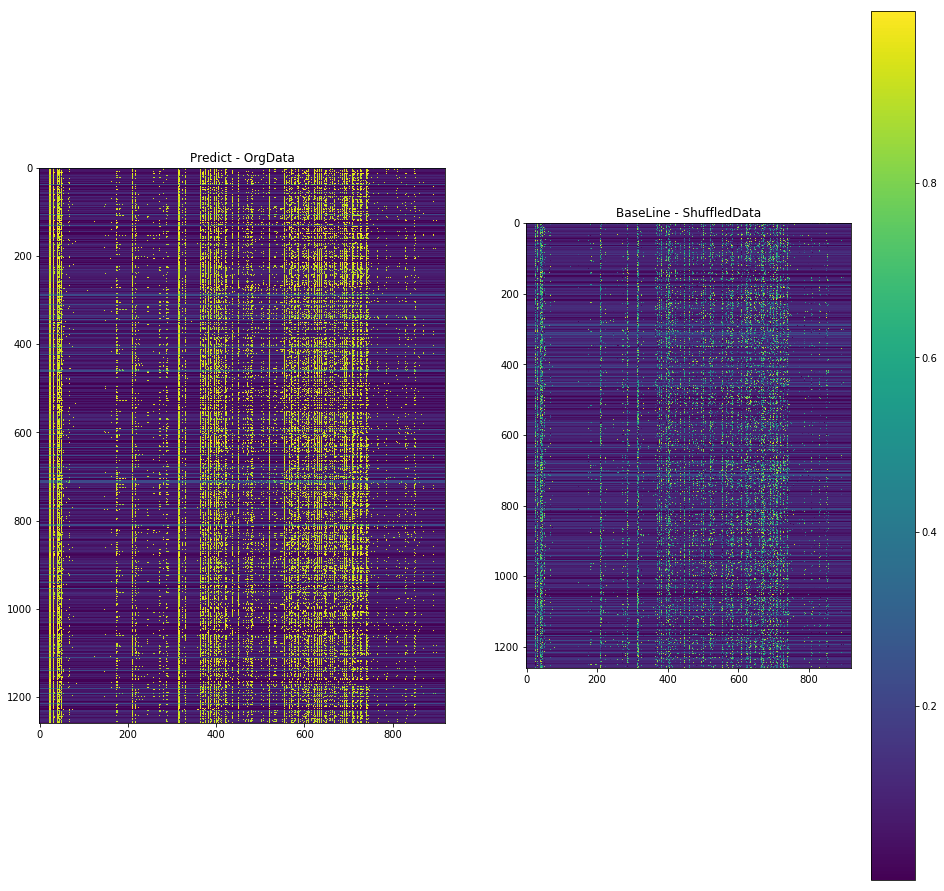

(1260, 130)


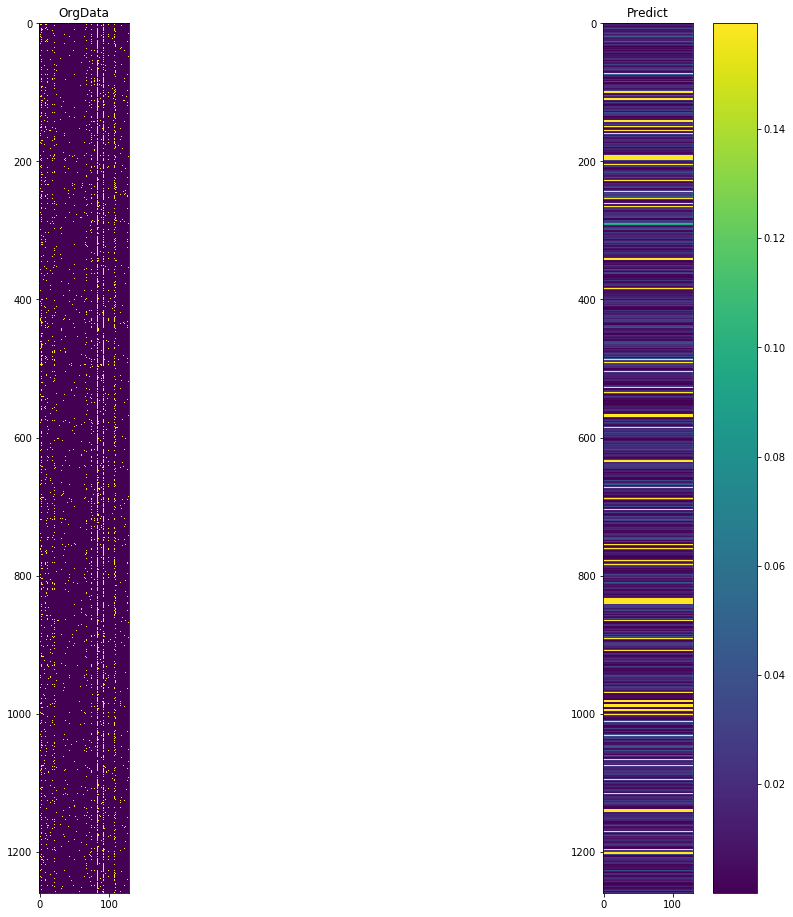

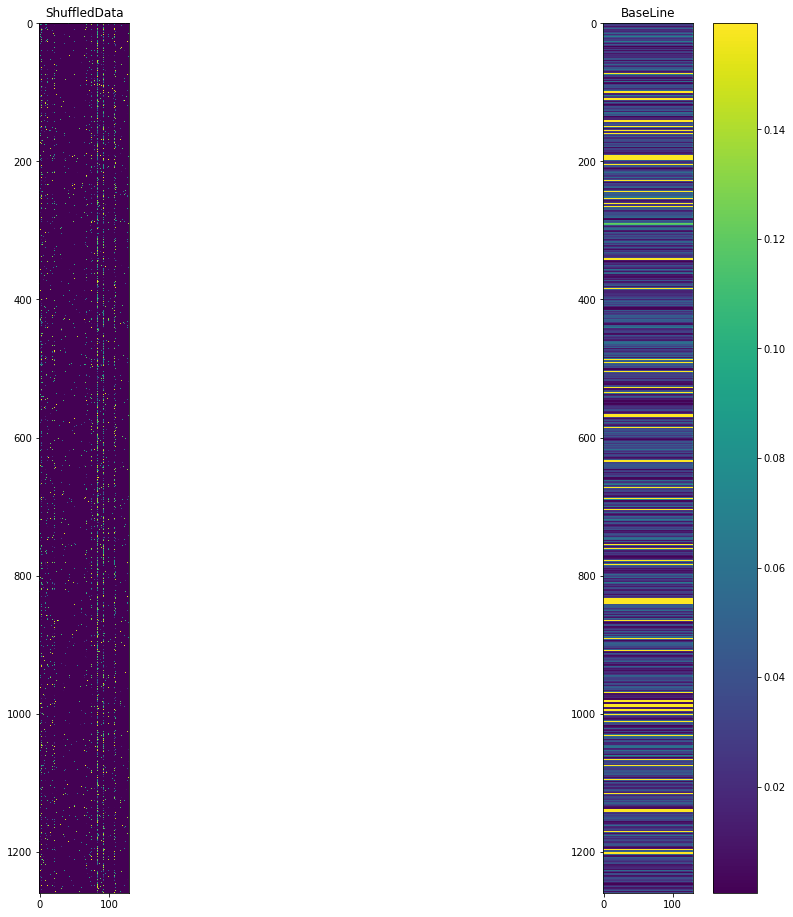

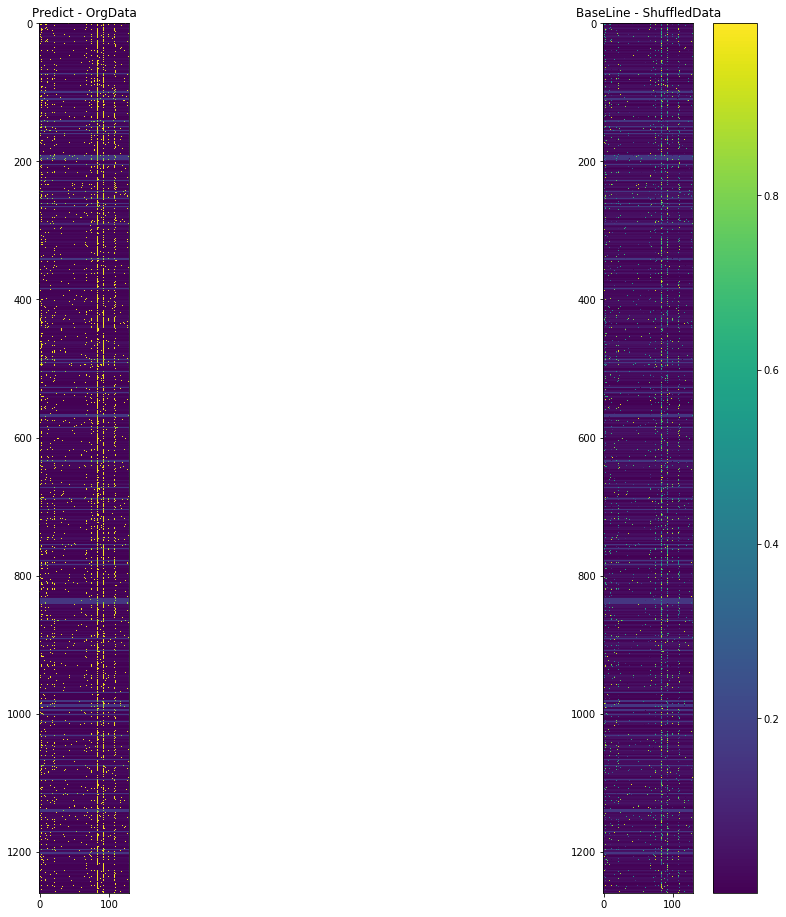

(189, 16)


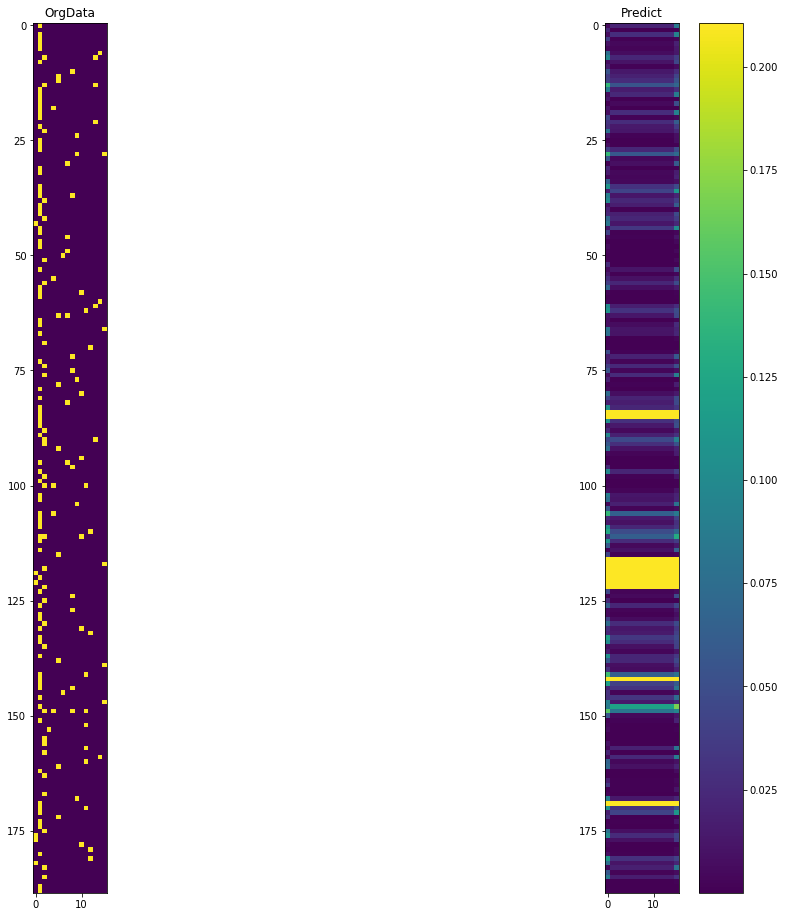

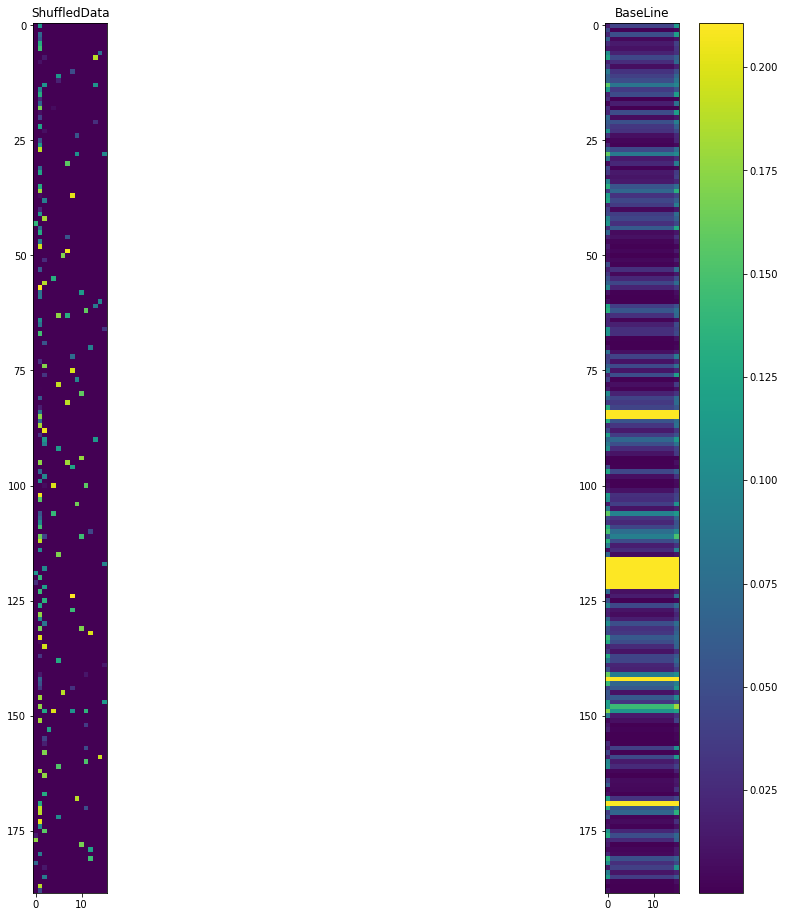

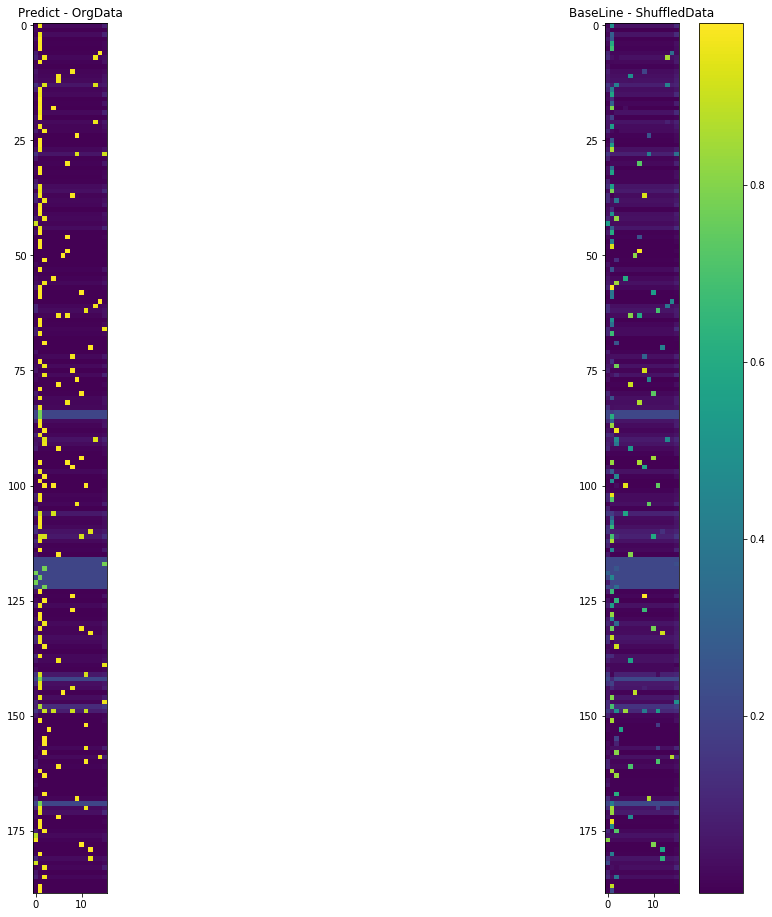

(1260, 189)


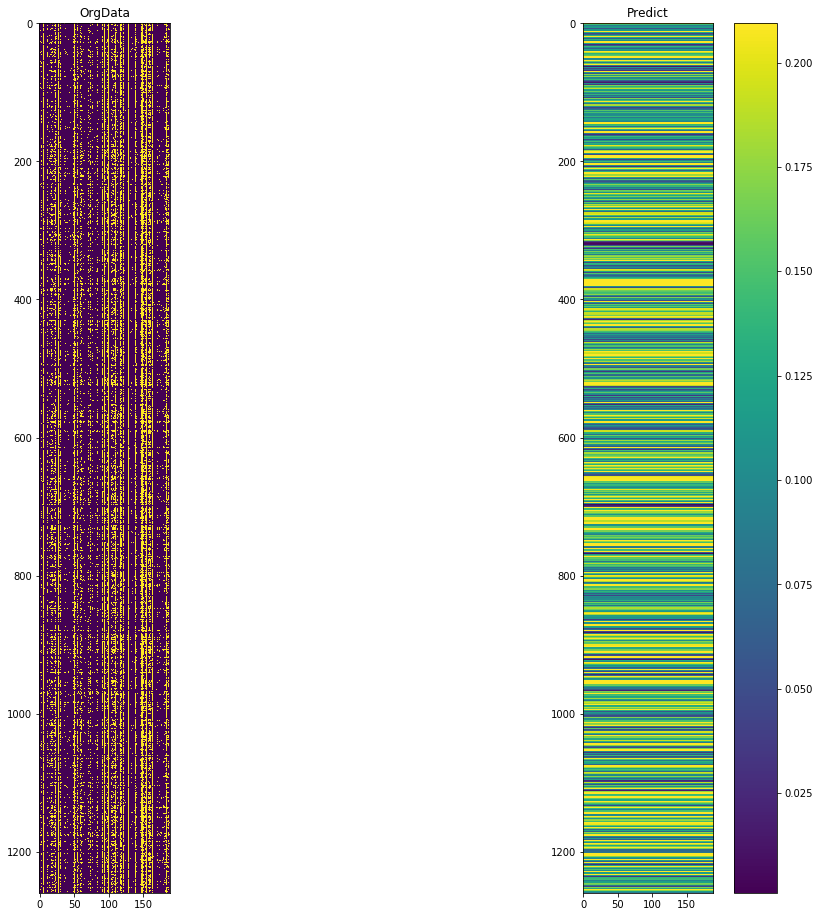

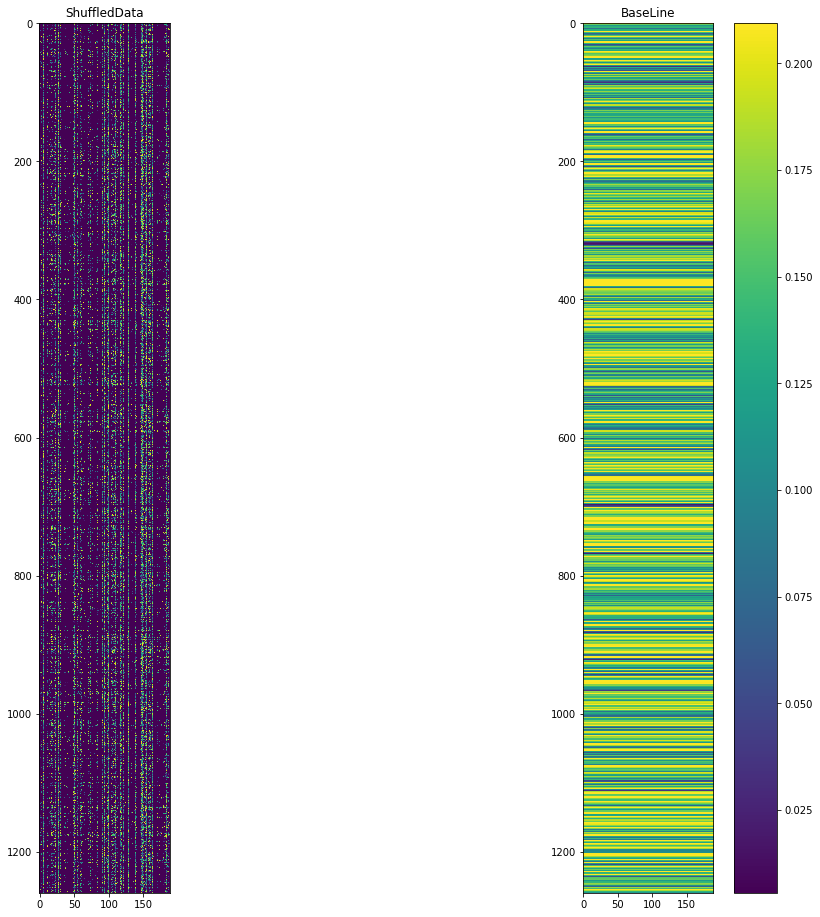

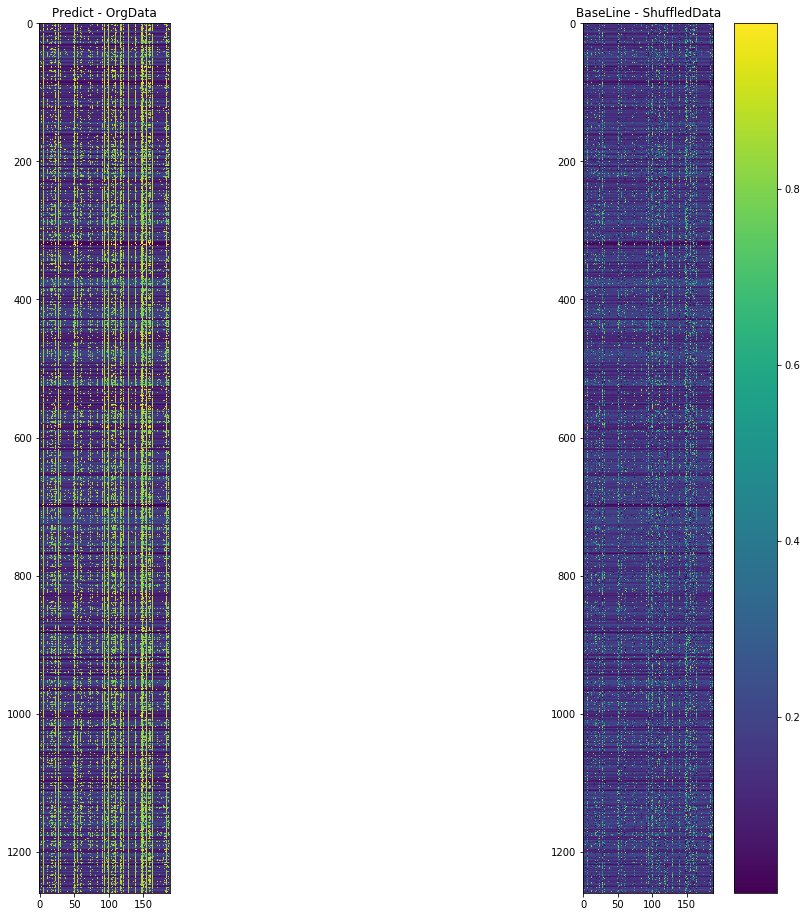

(1260, 7948)


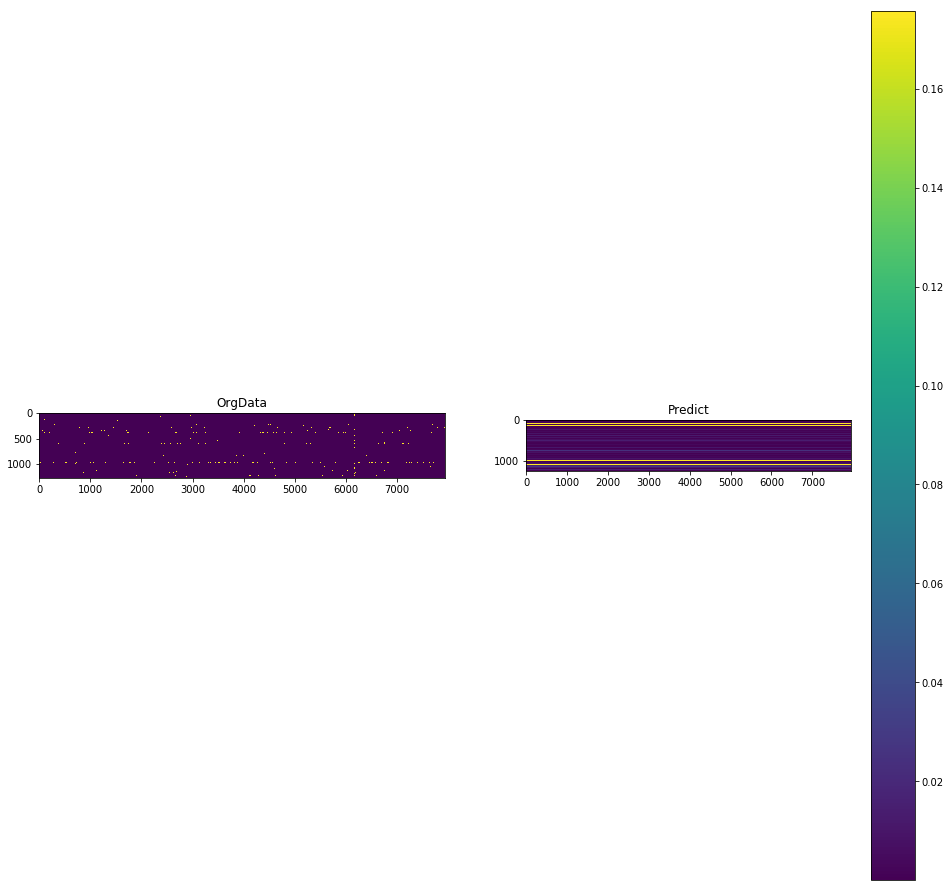

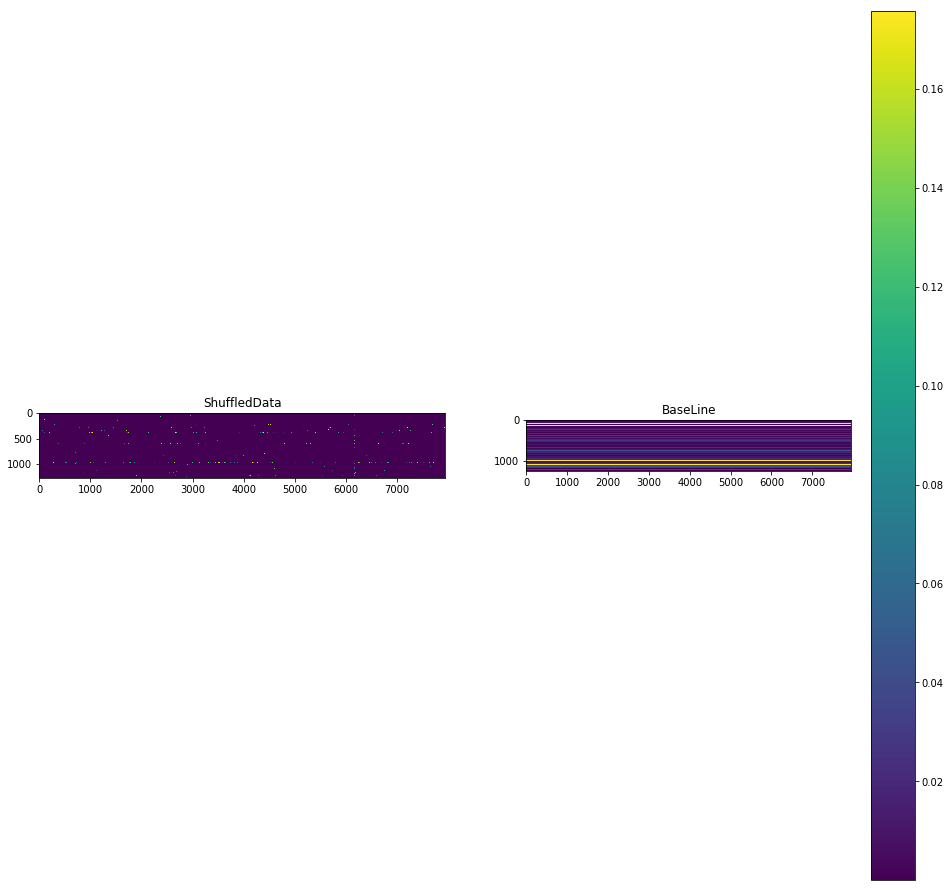

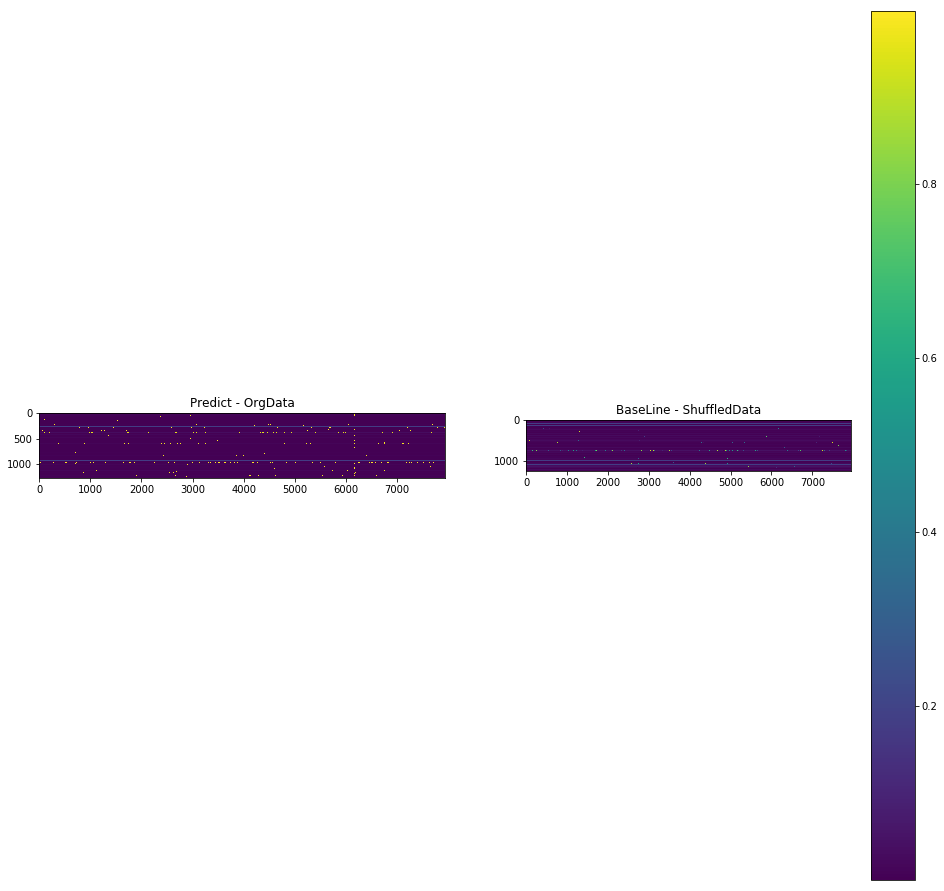

(1260, 1260)


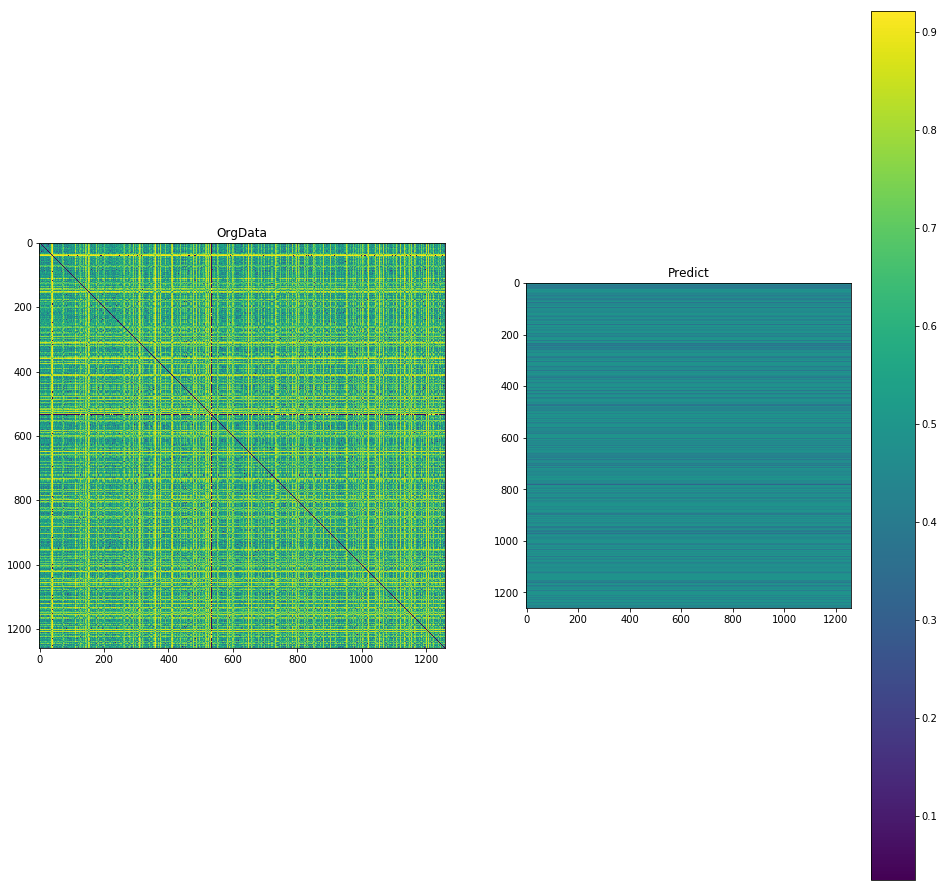

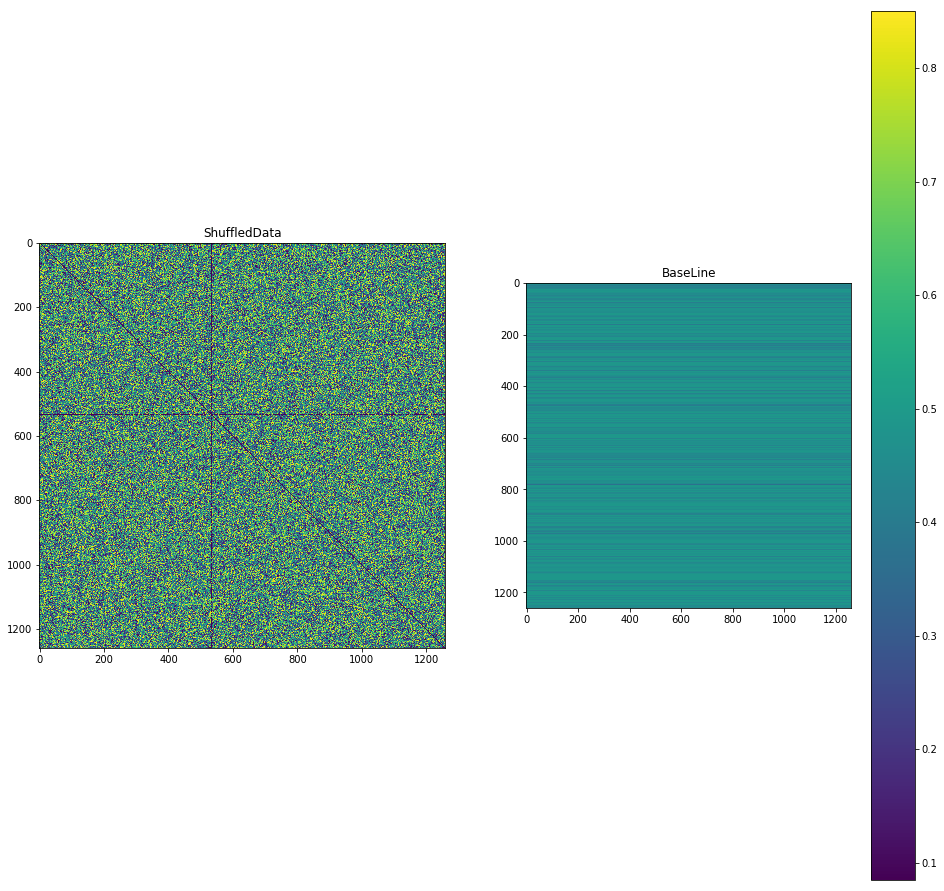

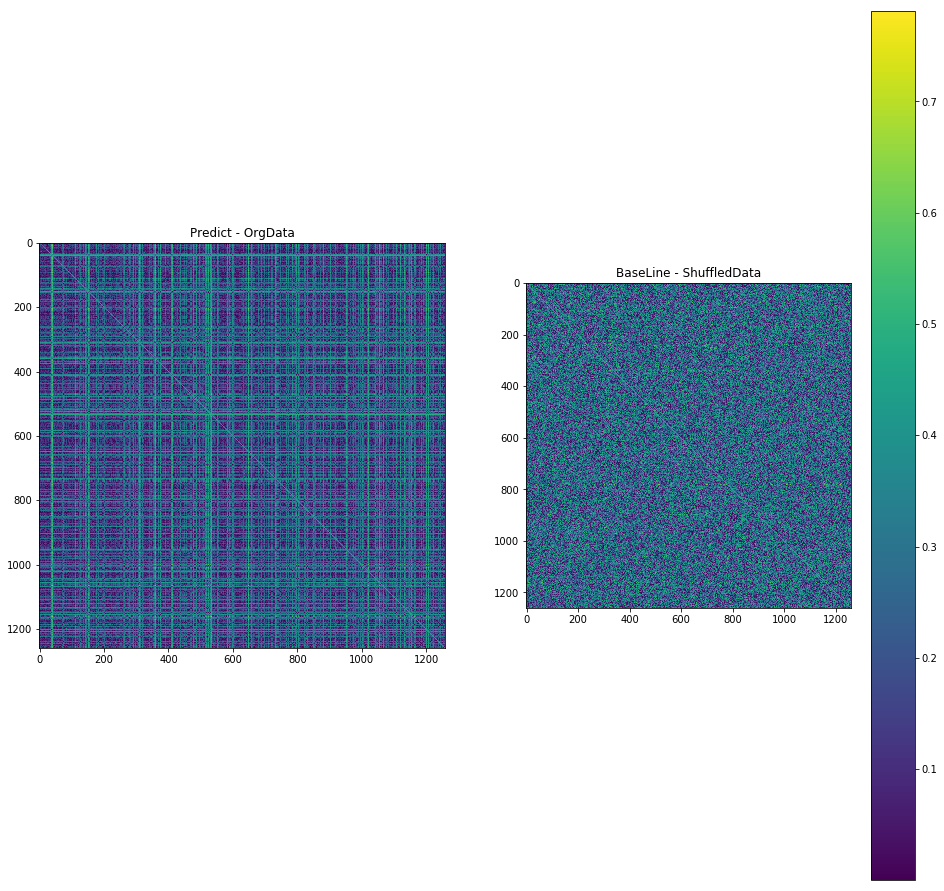

In [7]:
import matplotlib.pyplot as plt

path = '/mag/Experiments/Results/'+ str(numOfExperiment) + '/pharma/'

for i in range(len(model2.org_data)):
    _, row, col, _ = model2.org_data[i].shape
    org_data = model2.org_data[i].reshape(row, col)
    shuffled_data = model2.shuffled_data[i].reshape(row, col)
    predict = model2.predict_data[i].reshape(row, col)
    base_line = model2.base_line[i].reshape(row, col)
    print(org_data.shape)


    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('OrgData')
    plt.imshow(org_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('Predict')
    plt.imshow(predict)
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('ShuffledData')
    plt.imshow(shuffled_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine')
    plt.imshow(base_line)
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_randomData_vs_predictBaseLine.png')
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('Predict - OrgData')
    plt.imshow(np.abs(predict - org_data))
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine - ShuffledData')
    plt.imshow(np.abs(base_line - shuffled_data))
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_intersection.png')
    plt.show()
    plt.close()